In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import matplotlib as mpl
mpl.style.use('./style.mcstyle')   # noqa
from matplotlib import pyplot as plt
import astropy
import pandas as pd
from astropy.io import fits
from tqdm import tqdm
import h5py

from astropy.cosmology import Planck18
cosmo = Planck18

In [4]:
import os
import time

# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"  # noqa
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".50"  # noqa
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"  # noqa

import BFast
import numpy as np

/anvil/scratch/x-mho1/.conda/envs/cmass/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Testing stuff out

In [4]:

BoxSize = 1000.
grid = 128  # int(BoxSize/(1000/128))
fc = 3
dk = 3
Nbins = 20
kF = 2*np.pi/BoxSize
kmax = (fc + dk * (Nbins-1) + dk/2)*kF
print(f"kf = {kF}, kmax = {kmax}")

delta = np.random.randn(grid, grid, grid).astype(np.float32)*1e-3

start_time = time.time()

result = BFast.Bk(delta, BoxSize, 3, 3, 20, 'All', MAS='CIC',
                  fast=True, precision='float32', verbose=True,
                  file_path='/anvil/scratch/x-mho1/cmass-ili/scratch/bfast/')

end_time = time.time()

print(result.shape)
print(f"Execution time: {end_time - start_time} seconds")

kf = 0.006283185307179587, kmax = 0.38641589639154456
Loading Counts from /anvil/scratch/x-mho1/cmass-ili/scratch/bfast/BFast_BkCounts_Grid128_BoxSize1000.00_BinSize3.00kF_FirstCenter3.00kF_NumBins20_TriangleTypeAll_OpenTrianglesTrue_Precisionfloat32.npy
Considering 1015 Triangle Configurations (All), with kmax = 0.3864
(1015, 8)
Execution time: 6.548592567443848 seconds


In [8]:
kmax = 0.5
Nbins = 25
fc = kmax/kF/(Nbins+1/2)
print(f"fc = {fc}")

fc = 3.1206851586646143


In [9]:
# BoxSize = 1000.
# grid = 128  # int(BoxSize/(1000/128))
# fc = 3
dk = fc
# Nbins = 20
kF = 2*np.pi/BoxSize
kmax = (fc + dk * (Nbins-1) + dk/2)*kF
print(f"kf = {kF}, kmax = {kmax}")

kf = 0.006283185307179587, kmax = 0.5


In [ ]:
0.4 = (x + x * (y-1) + x/2) * z
0.4/z = x*(1+y-1+1/2)
0.4/z/(y+1/2) = x

In [20]:
k123 = result[:, :3]*kF
pk = result[:, 3:5]
bk = result[:, 6:7]
Ntriangles = result[:, 7]

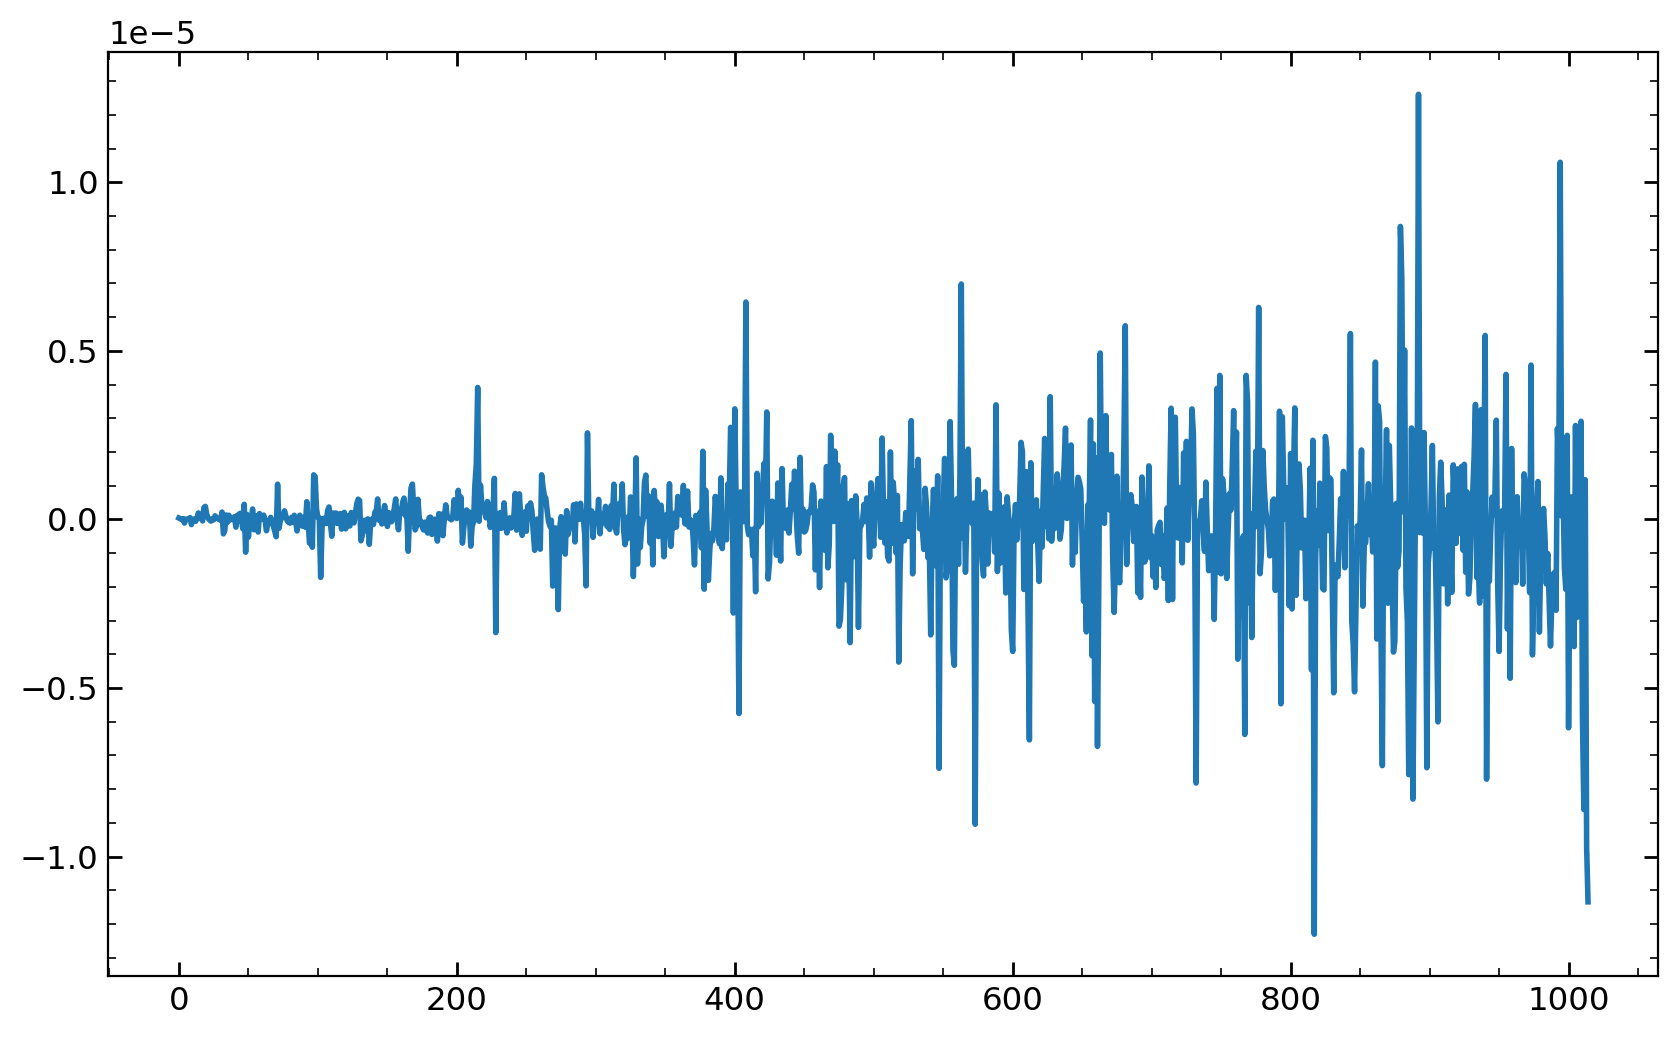

In [25]:
plt.plot(bk[:, 0]*np.prod(k123, axis=1))

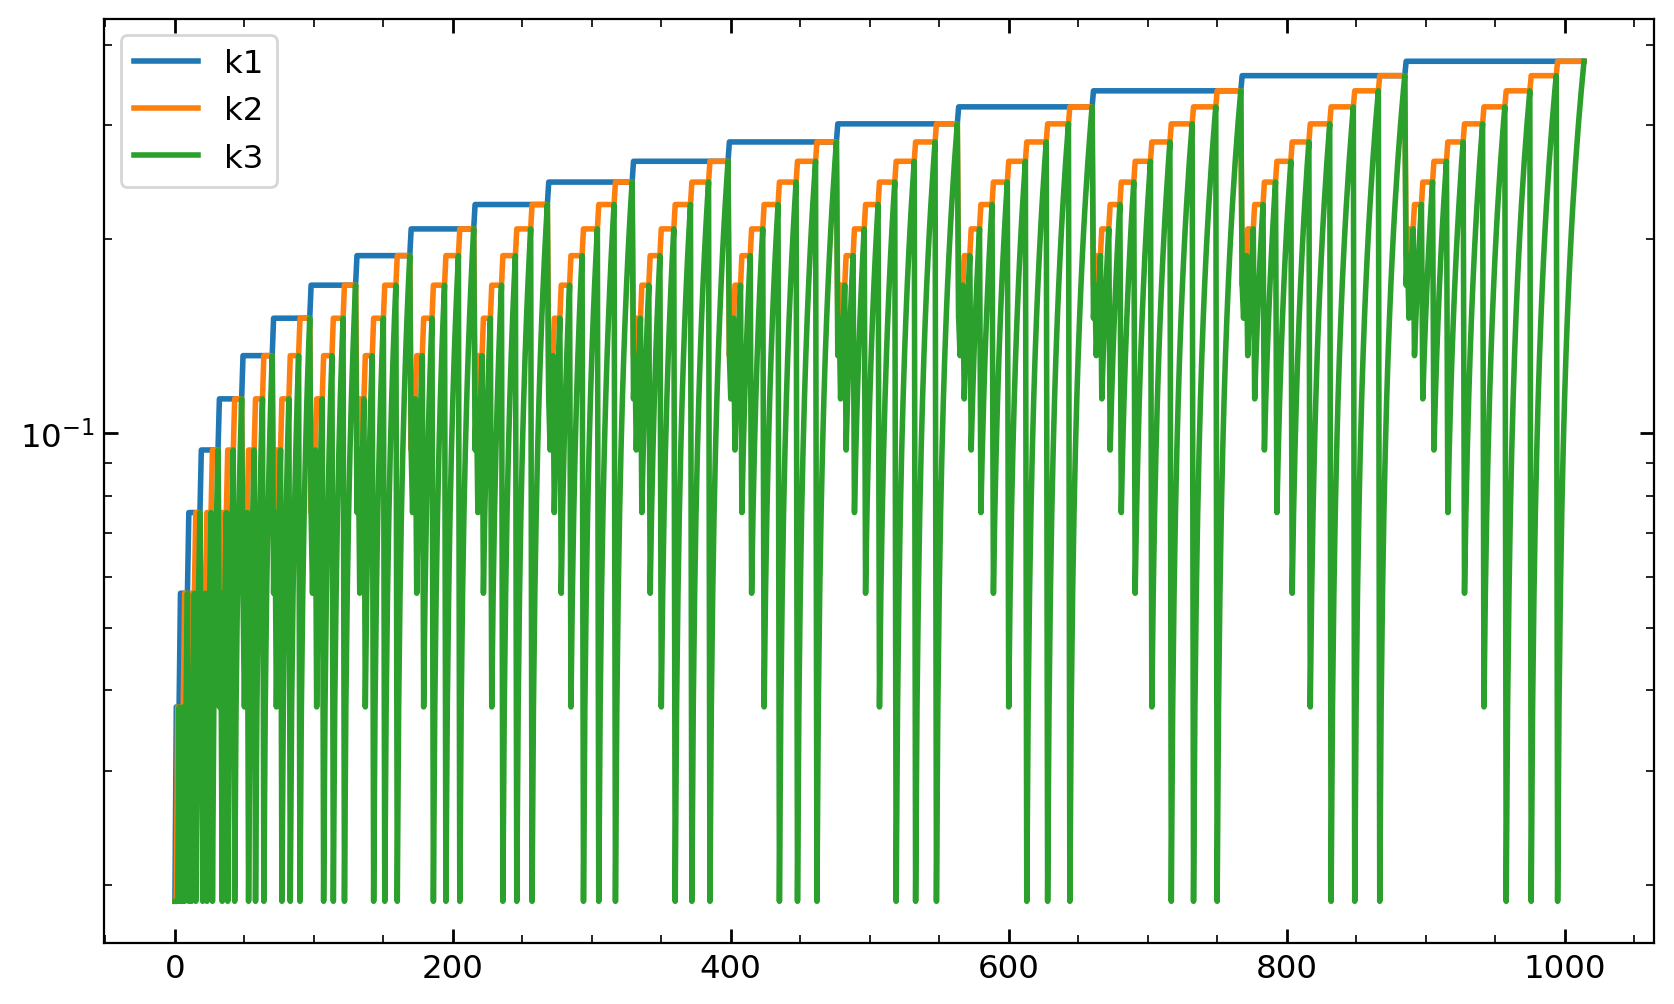

In [26]:
plt.semilogy()
for i in range(3):
    plt.plot(k123[:, i], label=f'k{i+1}')
plt.legend()

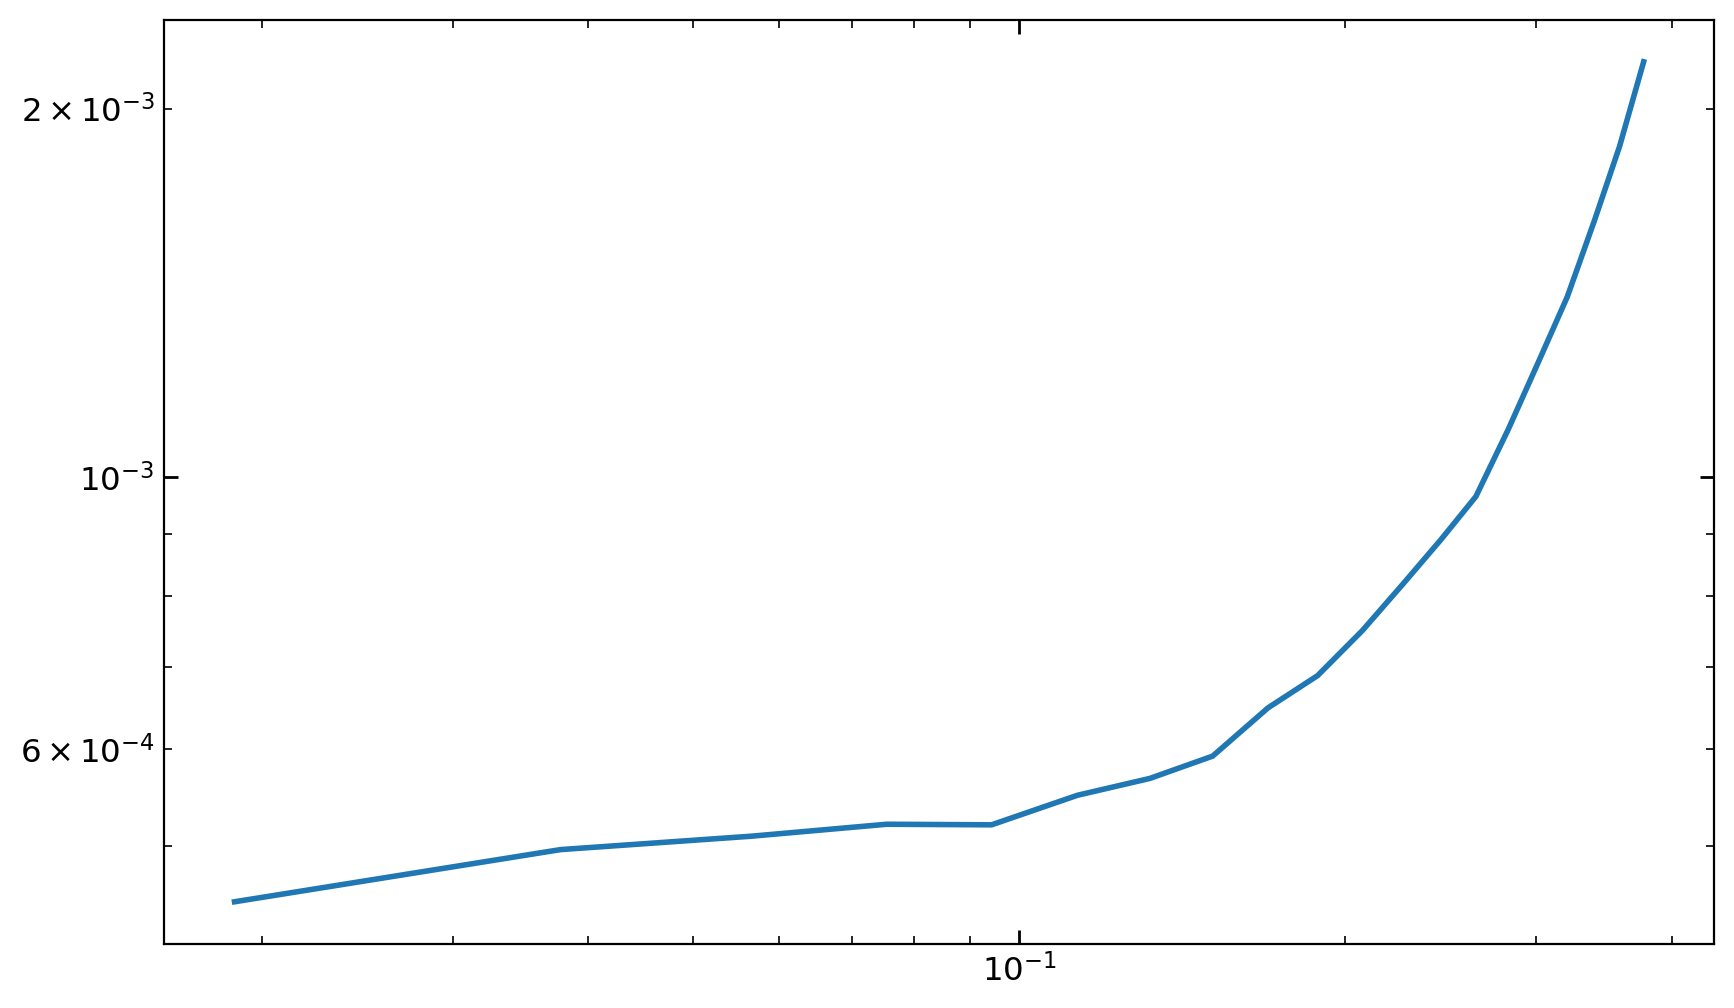

In [27]:
plt.loglog(k123[:, 0], pk[:, 0], label='P(k)')

In [19]:
L = 1000

Lmax = 3500.  # Mpc/h
kFmin = 2*np.pi/Lmax
kmax = 0.5  # h/Mpc
Nbins = 25  # Set due to memory limits for 3 Gpc/h box
# kbinning which allows Nbins in this range (from Bfast code)
dk = kmax/kFmin/(Nbins+1/2)

# find the closest to the fundamental mode
kF = 2*np.pi/L
Nbins = ((kmax - kF)/kFmin) // dk
fc = kmax/kFmin - (Nbins - 1/2) * dk  # center of first mode

print(f'kF = {kF}, Nbins = {Nbins}, fc = {fc}, dk = {dk}')

kF = 0.006283185307179587, Nbins = 25.0, fc = 10.922398055326141, dk = 10.922398055326152


### Checking outputs

In [18]:
import h5py
diagpath = '/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/L3000-N384/3/diag/ngc_lightcone/hod00031_aug00000.h5'

out = {}
with h5py.File(diagpath, 'r') as f:
    for k in f.keys():
        out[k] = f[k][...]
        print(k, out[k].shape)

Bk (1, 2269)
Bk_k123 (3, 2269)
Pk (665, 3)
Pk_k3D (665,)
Qk (1, 2269)
bPk (3, 2269)
bPk_k3D (3, 2269)


(-0.361374977696687, 1.0)

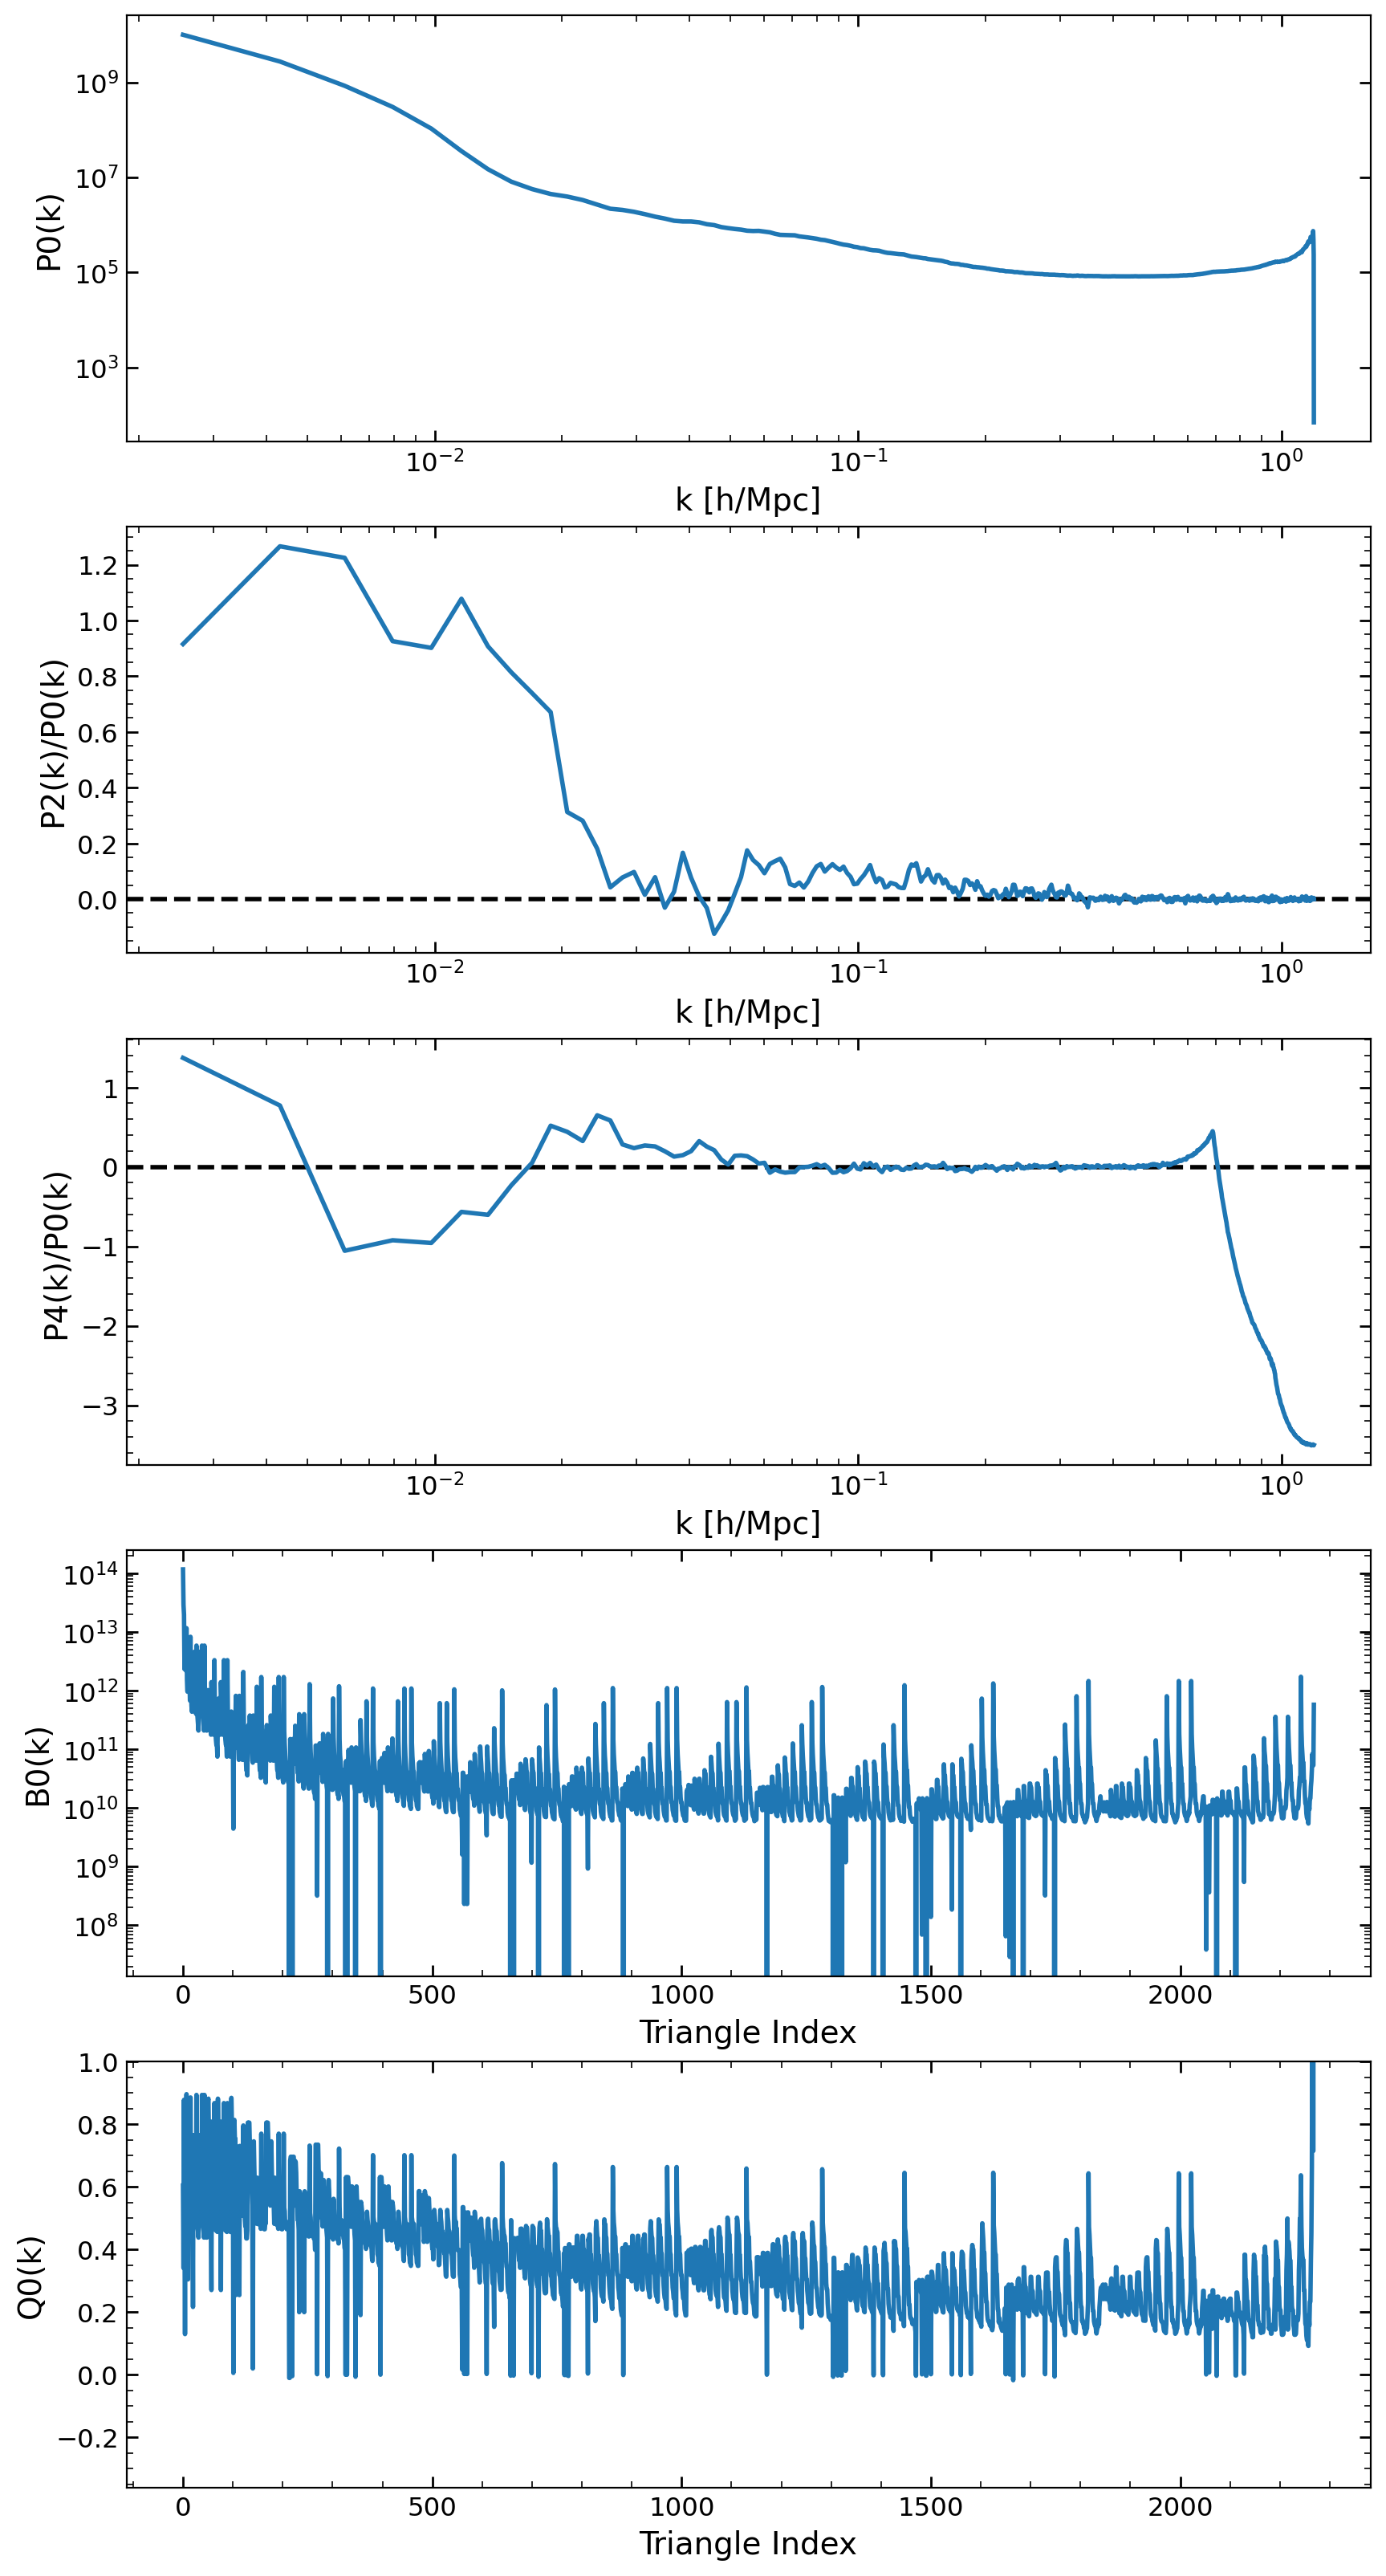

In [19]:
f, axs = plt.subplots(5, 1, figsize=(10, 20))

ax = axs[0]
ax.loglog(out['Pk_k3D'], out['Pk'][:, 0])
ax.set(xlabel='k [h/Mpc]', ylabel='P0(k)')

ax = axs[1]
ax.axhline(0, color='k', ls='--')
ax.semilogx(out['Pk_k3D'], out['Pk'][:, 1]/out['Pk'][:, 0])
ax.set(xlabel='k [h/Mpc]', ylabel='P2(k)/P0(k)')

ax = axs[2]
ax.axhline(0, color='k', ls='--')
ax.semilogx(out['Pk_k3D'], out['Pk'][:, 2]/out['Pk'][:, 0])
ax.set(xlabel='k [h/Mpc]', ylabel='P4(k)/P0(k)')

ax = axs[3]
ax.semilogy(out['Bk'][0])
ax.set(xlabel='Triangle Index', ylabel='B0(k)')

ax = axs[4]
ax.plot(out['Qk'][0])
ax.set(xlabel='Triangle Index', ylabel='Q0(k)')
ax.set_ylim(None, 1)